Z.W.Miller - Copyright 2018

In [26]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math 
import scipy 
%matplotlib inline
plt.style.use('seaborn')

In [27]:
 import numpy as np 
 import sklearn
 import matplotlib 
 import pandas as pd
 import sys
 libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))


Python Version: 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0] 

Matplotlib Version: 3.2.2
Numpy Version: 1.21.6
Pandas Version: 1.3.5


In [28]:
import numpy as np
import pandas as pd
from copy import copy

class svc: 

    def __init__(self, n_iter=10, lambd=0.01, verbose=False, add_bias=True, random_state=None):
        """
        Support Vector Machines work by trying to maximize the margin between the groups.
        This specific class will be built based on teh Pegasos methodology, which is
        a form of gradient descent for SVMs. It converges pretty quickly and is stable.
        If multiclass, automatically does one-vs-rest method.
        ---
        KWargs: 
        n_iter: number of epochs for the gradient descent
        lambd: learning rate for the gradient descent
        verbose: flag to set debug printing
        add_bias: flag for whether there is a y-intercept term
        random_state: sets state for reproducibility
        """
        self.w = None
        self.trained = False
        self.n_iter = n_iter
        self.lambd = lambd
        self.verbosity = verbose
        self.add_bias = add_bias
        if random_state:
            np.random.seed(random_state)
        self._data_cols = None

    def shuffle_data(self, X, y):
        """
        Given X and y, shuffle them together to get a new_X and new_y that maintain feature-target
        correlations. 
        ---
        Inputs:
        
        X: A numpy array of any shape
        y: A numpy array of any shape
        
        Both X and y must have the same first dimension length.
        
        Returns:
        X,y: two numpy arrays
        """
        assert len(X) == len(y)
        permute = np.random.permutation(len(y))
        return X[permute], y[permute]

    def fit(self, X, y):
        """
        Controller function for the fit. If there are only
        two classes, it trains a single model. If there are more
        it detects how many models it will need (one for each class)
        and builds a model for each class in a one-vs-rest method.
        """
        
        X = self.convert_to_array(X)
        y = self.convert_to_array(y)
        
        if self.add_bias:
            X = self.add_intercept(X)
        
        unique_classes = np.unique(y)
        self.num_classes = len(unique_classes)
        if self.num_classes == 2:
            new_y = copy(y)
            new_y[new_y==0] = -1
            self.train_model(X, new_y)
        else:
            self.models = [copy(self) for _ in range(self.num_classes)]
            for ix, val in enumerate(unique_classes):
                new_y = copy(y)
                new_y[new_y!=val] = -1
                new_y[new_y==val] = 1
                self.models[ix].train_model(X, new_y)
            
    def train_model(self,X,y):
        """
        Updates the weights, w, with a gradient descent method.
        The method is based on a heuristic function that recreates
        the margin maximization method found in "traditional" SVM.
        The indicator helps control the type of step taken, to speed
        convergence. Smaller steps are taken every epoch by scaling
        by epoch number.
        """
        if self.w == None:
            self.w = np.zeros(X.shape[1])
            
        t = 1
        for i in range(1,self.n_iter+1):
            shuf_X, shuf_y = self.shuffle_data(X,y)
            for data, true in zip(shuf_X, shuf_y):
                indicator = true*np.dot(data,self.w)
                if indicator < 1.:
                    self.w = (1-1/t)*self.w + (1/(self.lambd*t))*true*data
                else:
                    self.w = (1-1/t)*self.w
                if self.verbosity:
                    print(self.w)
            t+=1
        
    def predict(self,X):
        """
        If there are only 2 classes, projects the data onto the 
        axis of the decision boundary, then checks which side of 
        the boundary to use by taking the sign of the projection.
        If more than two, does a projection for each model and 
        chooses whichever class has the largest projection
        value (it's MOST in this class compared to others).
        """
        X = self.convert_to_array(X)
        
        if self.add_bias:
            X = self.add_intercept(X)
        
        if self.num_classes == 2:
            pred = np.sign(np.dot(X,self.w))  
            pred[pred < 0] = 0 
            return pred.reshape(-1,1)
        else:
            results = np.empty((X.shape[0],0))
            for model in self.models:
                pred = np.dot(X,model.w).reshape(-1,1)
                results = np.hstack((results, pred))
            return np.argmax(results, axis=1).reshape(-1,1)
      
    def score(self, X, y):
        """
        Uses the predict method to measure the accuracy of the model.
        ---
        In: X (list or array), feature matrix; y (list or array) labels
        Out: accuracy (float)
        """
        pred = self.predict(X)
        correct = 0
        for i,j in zip(y,pred):
            if i == j:
                correct+=1
        return float(correct)/float(len(y))

    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 

    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x

    def convert_to_array(self,x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x
    
    def add_intercept(self,X):
        """
        Adds an 'all 1's' bias term to function as the y-intercept
        """
        rows = X.shape[0]
        inter = np.ones(rows).reshape(-1,1)
        return np.hstack((X,inter))
    
     

# Let's get some data to see how it behaves

In [29]:
from sklearn.datasets import make_classification

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=45, n_clusters_per_class=1)


It will work with pandas or numpy arrrays. let's play with pandas for now.

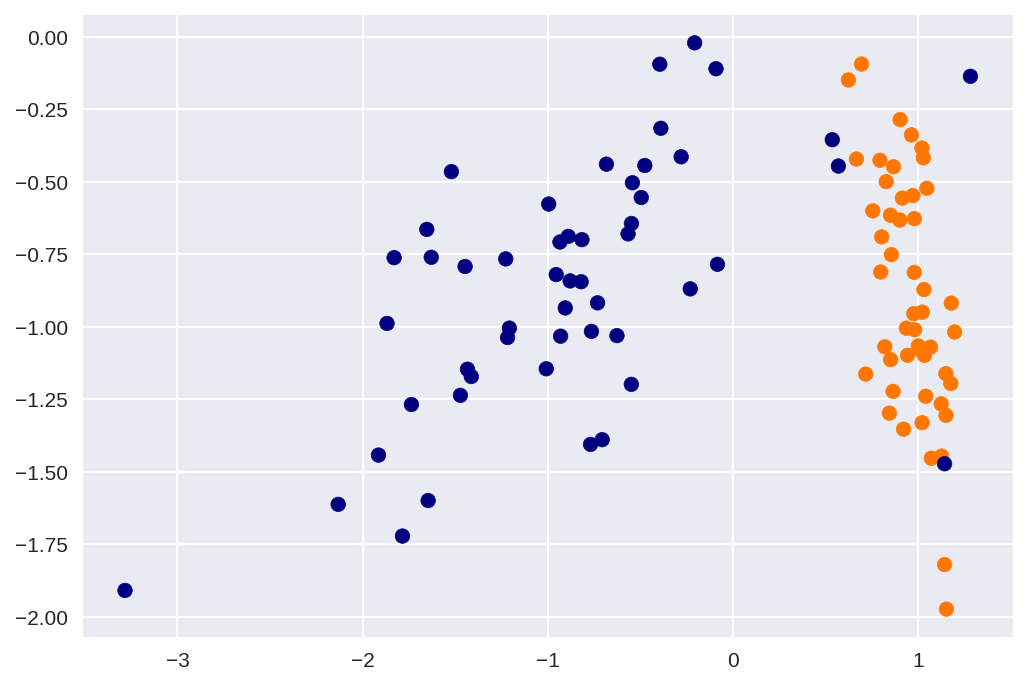

In [30]:
plt.figure(dpi=150)
plt.scatter(X[:,0],X[:,1],c=plt.cm.jet(y*200));

In [31]:
sv = svc(n_iter=1000, add_bias=True, verbose=False)

In [32]:
sv.fit(X,y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [33]:
sv.score(X,y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


0.96

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: The following kwargs were not used by contour: 'camp'


0.96


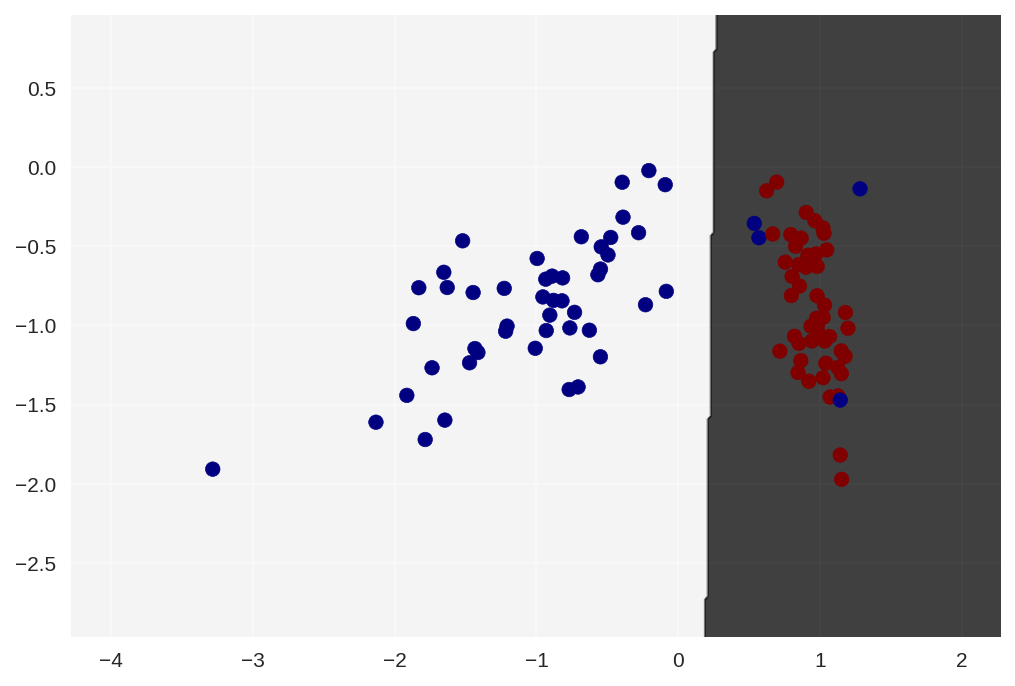

In [34]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


print(sv.score(X,y))
X0, X1 = X[:,0], X[:,1]
xx, yy = make_meshgrid(X0, X1)
plt.figure(dpi=150)
ax = plt.gca()
plot_contours(ax, sv, xx, yy,camp=plt.cm.RdBu_r, alpha=0.8)
plt.scatter(X[:,0],X[:,1],c=plt.cm.jet(y*2000));


In [35]:
from sklearn.datasets import load_iris
X = load_iris().data
y = load_iris().target

In [36]:
sv = svc(n_iter=10000, random_state=42)

In [ ]:
sv.fit(X[:,[1,2]],y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
print(sv.score(X[:,[1,2]],y))
X0, X1 = X[:, 1], X[:, 2]
xx, yy = make_meshgrid(X0, X1)
plt.figure(dpi=150)
ax = plt.gca()
plot_contours(ax, sv, xx, yy,camp=plt.cm.RdBu_r, alpha=0.8)
plt.scatter(X[:,1],X[:,2],c=plt.cm.jet(y*200));
plt.title("Testing One-VS-Rest Method")
plt.xlabel("X_1")
plt.ylabel("X_2");